In [10]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [11]:
# Считывание файла csv для анализа
hw = pd.read_csv('/home/jupyter-o-demchenko-18/statistic/Lessons9/Exercise/hw_bootstrap.csv', sep=';', index_col=0)

In [12]:
# проверяю тип переменных
hw.dtypes

value                object
experimentVariant    object
dtype: object

In [13]:
# поиск пропущенных значений
hw.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [14]:
# замена запятых в столбце value на точки
hw['value'] = hw['value'].str.replace(",", '.')

In [15]:
# замена типа переменной object в колонке values на float
hw['value'] = hw['value'].astype(float, errors = 'raise')

In [16]:
# оценка объема выборок
hw.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,500


In [17]:
# рассчет среднего значения в выборках
hw.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [18]:
# рассчет медианы в выборках
hw.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


In [19]:
# создаем отдельный массив данных для двух выборок(Control и Treatment)
hw_control = hw[hw['experimentVariant'] == 'Control']['value']
hw_Treatment = hw[hw['experimentVariant'] == 'Treatment']['value']


In [23]:
# Рассчет критерия Манна-Уитни
mannwhitneyu_mean = mannwhitneyu(hw_control, hw_Treatment)
mannwhitneyu_mean

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [20]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 500, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

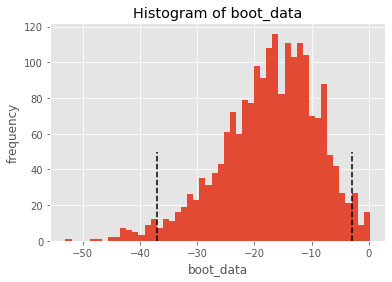

In [21]:
# Метод Bootstrap для подсчета распределения средних значений подвыборок
booted_data_mean = get_bootstrap(hw_control, hw_Treatment, boot_it = 2000)

In [119]:
# Вывод уровня значимости для метода Bootstrap по средним значения
booted_data_mean["p_value"]

0.03329901106788228

In [24]:
# Вывод доверительного интервала для метода Bootstrap по средним значения
booted_data_mean["ci"]

,0
0.025,-36.975010
0.975,-3.013826


In [27]:
# Создадим таблицу рассчитанных уровней значимости, полученных разными методами
df_mean = pd.DataFrame({
                      'bootstrap_pvalue': [0.03329901106788228],
                      'mannwhitneyu': [0.8592148582485579]
                      })
df_mean

,bootstrap_pvalue,mannwhitneyu
0,0.033299,0.859215


ВЫВОД: Уровень значимости по Манну-Уитни не имеет статистичеки значимого результата, в то время как bootstrap метод показал, что наблюдения имеют статистические различия(pvalue = 0.033299, а в доверительный интервал не входит 0). Из такого распределения итоговых данных сложно сделать вывод о наличии или отсутствии различиях в выборках на основе использования среднего значения в методе bootstrap. Предположительно имеются выбросы во второй выборке, т.к. полученный доверительный интервал имеет знак "-"
Примечание: при расчете среднего значения в выборках, значения имеют сильное расхождения, в то время как медианные значения очень близки друг другу, да и график распределения средних значений(по методу bootstrap) сильно сдвинут в одну сторону, поэтому для лальнейшей оценки необходимо исследовать выборки

МЕТОД BOOTSTRAP ДЛЯ МЕДИАННЫХ ЗНАЧЕНИЙ 

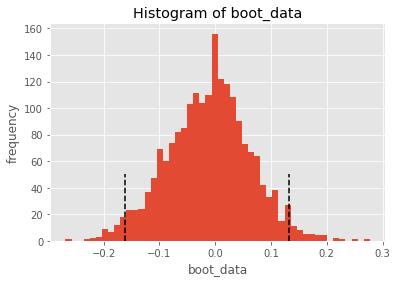

In [34]:
# Метод Bootstrap для подсчета распределения медианных значений подвыборок
booted_data_median = get_bootstrap2(hw_control, hw_Treatment, boot_it = 2000)

In [35]:
# Вывод уровня значимости для метода Bootstrap по медианным значения
booted_data_median["p_value"]

0.8790686844172859

In [36]:
# Вывод доверительного интервала для метода Bootstrap по медианным значения
booted_data_median["ci"]

,0
0.025,-0.161904
0.975,0.131621


In [37]:
# Создадим таблицу рассчитанных уровней значимости, полученных разными методами
df_median = pd.DataFrame({
                  'bootstrap_pvalue': [0.8790686844172859],
                  'mannwhitneyu': [0.8592148582485579]
                  })
df_median

,bootstrap_pvalue,mannwhitneyu
0,0.879069,0.859215


ВЫВОД: Оба метода показали отсутствие статистически значимых различий в выборках для групп control и Treatment. Также 0 входит в доверительный интервал, что также подтверждает отсутствие значимых различий в выборках.

Резюмируя вышесказанное, для оценки стат. значимых различий между двумя выбокарми (Сontrol и Treatment) кейс Bootstrap(Median) + критерий значимости Манна-Уитни дает наиболее реалистичную оценку различий между выборками в данном исследовании. По результатам исследования можно сделать вывод, что выборки не имеют сильных различий, но для дальнейшего исследования требуется пересмотр выборки (Treatment), в которой возможны выбросы значений.